In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
data_simple = pd.read_csv('data_simple.csv', encoding = "ISO-8859-1", low_memory=False, index_col=0)

In [11]:
def getDfSummary(input_data):
    summary = input_data.describe().transpose()
    summary = summary.drop(['count'], axis=1)

    number_distinct = input_data.unstack().groupby(level=0).nunique(dropna=True)
    number_distinct.name = "number_distinct"

    number_nan = input_data.isnull().sum()
    number_nan.name = "number_nan"
    
    data_type = input_data.dtypes
    data_type.name = "type"
    
    count = input_data.count()
    count.name='valid_count'

    output_data = pd.concat([data_type,summary, number_distinct, count, number_nan], axis=1)

    
    return output_data


In [13]:
#verify that 'BOFI_NBR','DFDN_SEQ_NBR','SYS_NBR', 'SADA_CODE', 'AREG_SEQ_NBR' uniquely identify this table
#each row represents an arrest
data_simple[data_simple.duplicated(['BOFI_NBR','DFDN_SEQ_NBR','SYS_NBR', 'SADA_CODE'],keep=False)]

,SADA_CODE,BOFI_NBR,DFDN_SEQ_NBR,SCREENING_DISP_CODE,SYS_NBR,POLICE_RPT_DATE,POLICE_RPT_DAYS,SCREENING_DAYS,SCREENING_DISP_DATE,ARREST_CREDIT_CODE,...,SADA_DOB,SADA_RACE,SADA_SEX,SADA_PARTY,JUVENILE_FLAG,CRIMINAL_FLAG,FBI_NBR,DOB,SEX,RACE


In [14]:
data_simple['CHRG_ACCEPTED'] = np.where(data_simple['SCREENING_DISP_CODE']==230,1,0)
data_simple['CHRG_REJECTED'] = np.where(data_simple['SCREENING_DISP_CODE']!=230,1,0)

In [15]:
by_sada = data_simple.groupby(['SADA_CODE'])['CHRG_ACCEPTED','CHRG_REJECTED'].sum()

In [16]:
by_sada.shape

(302, 2)

In [17]:
by_sada['NBR_CASES'] = by_sada['CHRG_ACCEPTED'] + by_sada['CHRG_REJECTED'] 
by_sada['CHRG_RATE'] = by_sada['CHRG_ACCEPTED']/(by_sada['NBR_CASES'])

In [18]:
getDfSummary(by_sada)

,type,mean,std,min,25%,50%,75%,max,number_distinct,valid_count,number_nan
CHRG_ACCEPTED,int64,360.062914,806.982328,0.0,4.000000,22.500000,261.750000,6423.0,159,302,0
CHRG_REJECTED,int64,477.874172,1152.450253,0.0,1.000000,21.000000,437.500000,10671.0,153,302,0
NBR_CASES,int64,837.937086,1910.870086,1.0,6.000000,51.000000,727.750000,17094.0,175,302,0
CHRG_RATE,float64,0.572253,0.307570,0.0,0.377527,0.564272,0.837661,1.0,193,302,0


(array([ 257.,   24.,   11.,    4.,    2.,    2.,    1.,    0.,    0.,    1.]),
 array([  1.00000000e+00,   1.71030000e+03,   3.41960000e+03,
          5.12890000e+03,   6.83820000e+03,   8.54750000e+03,
          1.02568000e+04,   1.19661000e+04,   1.36754000e+04,
          1.53847000e+04,   1.70940000e+04]),
 <a list of 10 Patch objects>)

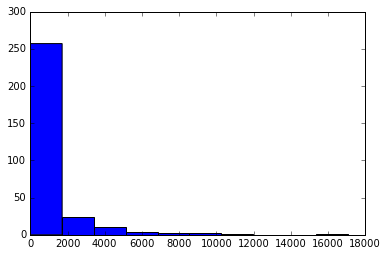

In [19]:
#histogram of number of cases seen by each screener
plt.hist(by_sada['NBR_CASES'])

(array([ 31.,   7.,  11.,  43.,  37.,  35.,  32.,  20.,  28.,  58.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

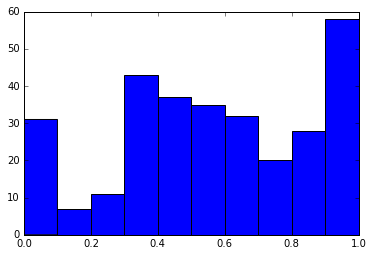

In [20]:
#plot histogram ofr acceptance rate

#drop
plt.hist(by_sada['CHRG_RATE'])

In [21]:
def to_date(col):
    '''Given a pandas series, returns pandas dates for non-missing valid dates'''
    col.dropna(inplace=True)
    col = col[col!=0]
    col = col.astype(int)
    converted = pd.to_datetime(col, format='%Y%m%d')
    return converted
    
    
    

In [22]:
compare_dates=pd.DataFrame()
compare_dates['ADD_DATE'] = to_date(data_simple['ADD_DATE'])
compare_dates['ARREST_DATE'] = to_date(data_simple['ARREST_DATE'])

In [23]:
compare_dates['DATE_CHECK'] = compare_dates['ADD_DATE']==compare_dates['ARREST_DATE']

In [24]:
compare_dates[(compare_dates['DATE_CHECK']==False)&(pd.isnull(compare_dates['ARREST_DATE'])==False)].shape

(102204, 3)

In [25]:
compare_dates['YEAR'] = pd.DatetimeIndex(compare_dates['ARREST_DATE']).year 
compare_dates['MONTH'] = pd.DatetimeIndex(compare_dates['ARREST_DATE']).month 
compare_dates['YM'] = compare_dates['ARREST_DATE'].map(lambda x: x.strftime('%Y-%m') if pd.notnull(x) else '') 


In [26]:
#NUMBER_DISTINCT is wrong for ARREST_DATE.  Unique column is right.
getDfSummary(compare_dates)

,type,mean,std,min,25%,50%,75%,max,number_distinct,valid_count,number_nan
ADD_DATE,datetime64[ns],NaN,NaN,NaN,NaN,NaN,NaN,NaN,3305,150758,0
ARREST_DATE,datetime64[ns],NaN,NaN,NaN,NaN,NaN,NaN,NaN,4258,148056,2702
DATE_CHECK,bool,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,150758,0
MONTH,float64,6.421415,3.373101,1.0,4.0,6.0,9.0,12.0,12,148056,2702
YEAR,float64,1994.215628,3.287641,1901.0,1991.0,1994.0,1997.0,1999.0,40,148056,2702
YM,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,251,150758,0


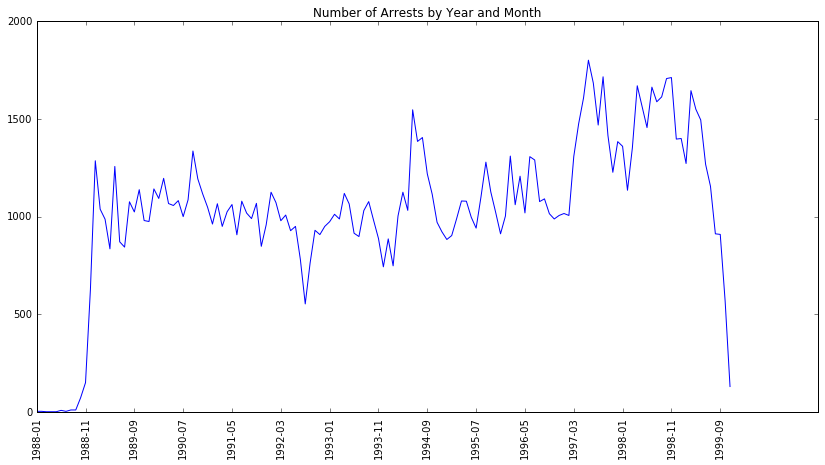

In [30]:
by_ym = compare_dates[compare_dates['YEAR']>=1988].groupby('YM')['YM'].count()
plt.figure(figsize=(14, 7))
plt.title('Number of Arrests by Year and Month')
plt.plot(np.arange(0,len(by_ym)),by_ym)
plt.tick_params(which='major')
plt.xticks(np.arange(0,len(by_ym),10), by_ym.index[::10], rotation='vertical');

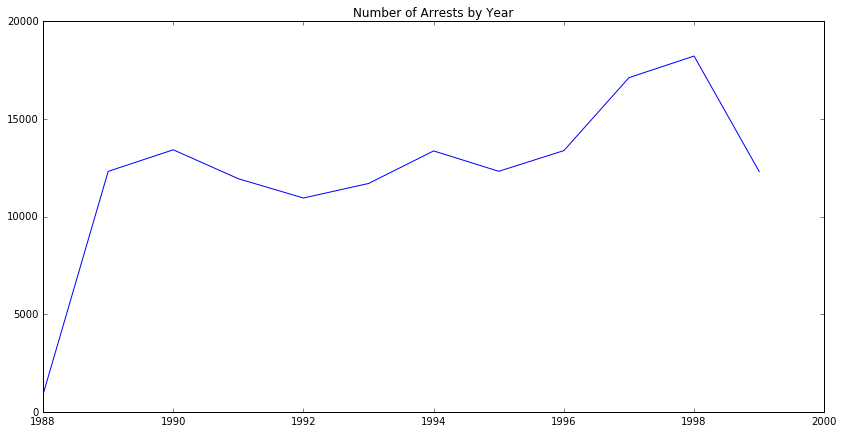

In [29]:
by_year = compare_dates[compare_dates['YEAR']>=1988].groupby('YEAR')['YEAR'].count()
plt.figure(figsize=(14, 7))
plt.title('Number of Arrests by Year')
plt.plot(by_year.index,by_year)

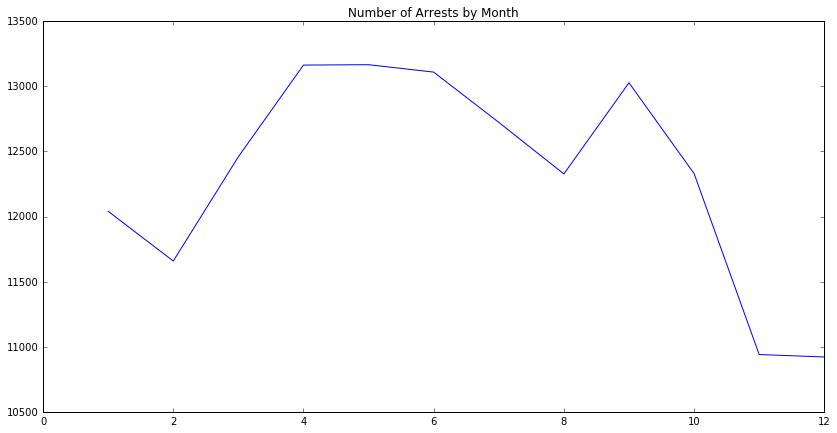

In [31]:
by_month = compare_dates[compare_dates['YEAR']>=1988].groupby('MONTH')['MONTH'].count()
plt.figure(figsize=(14, 7))
plt.title('Number of Arrests by Month')
plt.plot(by_month.index,by_month)